# CS5495 - Explainable AI
# Lecture 5a - MLP and CNN
## Prof. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Multiclass Logistic Regressin
2. Multilayer Perceptron
3. Convolutional Neural Network
4. Deep Networks
5. Feature Visualization
6. Network Dissection

In [1]:
# setup
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # display larger images
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Revisiting Multiclass logistic regression
- Consider a multi-class classification problem with $C$ classes
  - class labels $y\in \{1,\cdots,C\}$
  - equivalently, class vectors: 
  $$\mathbf{y} \in \{\begin{bmatrix}1\\0\\\vdots\\0\end{bmatrix},\begin{bmatrix}0\\1\\\vdots\\0\end{bmatrix},\cdots,\begin{bmatrix}0\\0\\\vdots\\1\end{bmatrix} \} = \{\mathbf{e}_1,\mathbf{e}_2,\cdots,\mathbf{e}_C\}$$
    - $\mathbf{e}_j$ is the canonical vector.


# Linear functions
- Construct $C$ linear functions, one for each class
  - $g_j(\mathbf{x}) = \mathbf{w}_j^T \mathbf{x}$, for $j=\{1,\cdots,C\}$
  - $\mathbf{w}_j$ is the weight vector for the j-th class.
  - (to reduce clutter, we implicitly include the bias term)
- Combine into a vector-valued function ($\mathbb{R}^C$):
  - $\mathbf{g}(\mathbf{x}) = \begin{bmatrix}g_1(\mathbf{x})\\\vdots\\g_C(\mathbf{x})\end{bmatrix} = \mathbf{W}^T 
  \mathbf{x}$, 
  - Weight matrix: $\mathbf{W} = [\mathbf{w}_1,\cdots,\mathbf{w}_C]$

# Softmax function

- Given a real vector $\mathbf{a}\in\mathbb{R}^C$
- Let $s_j(\mathbf{a}) = \frac{\exp(a_j)}{\sum_{k=1}^C \exp(a_k)}$
  - if $a_j \gg a_i$, then the exponent will cause $s_j(\mathbf{a})\rightarrow 1$.
  - denominator ensures $\sum_{j=1}^C s_j(\mathbf{a})=1$.
- Let $\mathbf{s}(\mathbf{a}) = [s_1(\mathbf{a}) \cdots s_C(\mathbf{a})]^T$
  - the output vector is ~1 in the dimension of $\mathbf{a}$ with largest value, and 0 elsewhere.
  - called the **softmax** function ("soft" because the values can be between 0 and 1)

# Mapping to probabilities
- Define the probability of the j-th class $p(y=j|\mathbf{x})$ as:
  - $p(y=j|\mathbf{x}) = f_j(\mathbf{x}) = s_j(\mathbf{g}(\mathbf{x})) = \frac{\exp(g_j(\mathbf{x}))}{\sum_{k=1}^C \exp(g_k(\mathbf{x}))}$
    - if $g_j(\mathbf{x}) \gg g_i(\mathbf{x})$, then the exponent will cause numerator to be very large, and thus $p(y=j|\mathbf{x})\rightarrow 1$.
    - the class with largest response $g_j(\mathbf{x})$ will have highest probability.
    - denominator ensures probabilities sum to 1 over classes.
- Finally, define the posterior probability vector:
$$\begin{bmatrix}p(y=1|\mathbf{x})\\\vdots\\p(y=C|\mathbf{x})\end{bmatrix} = \mathbf{f}(\mathbf{x}) = \mathbf{s}(\mathbf{g}(\mathbf{x})))$$

# Example
- linear functions and mapped probabilities

In [3]:
x = linspace(-5,5,100)
w = array([-2, 0.5, 2])
b = array([0, 3, 0])

g = x[:,newaxis]*w+b

s = exp(g)
s /= sum(s,axis=1)[:,newaxis]

sfig = plt.figure()
plt.subplot(2,1,1)
plt.plot(x, g[:,0], label='$g_1(x)$')
plt.plot(x, g[:,1], label='$g_2(x)$')
plt.plot(x, g[:,2], label='$g_3(x)$')
plt.legend()
#plt.title('linear function')
plt.ylabel('$g_j(x)$')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(x, s[:,0], label='p(y=1|x)')
plt.plot(x, s[:,1], label='p(y=2|x)')
plt.plot(x, s[:,2], label='p(y=3|x)')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('p(y=j|x)')
#plt.title('probability')
plt.close()

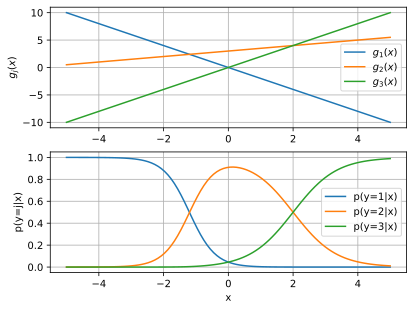

In [4]:
sfig

# Learning with MLE
- let $\mathbf{y}$ be the *class vector* representation of the class
  - i.e. $y_j=1$ indicates class $y=j$, and 0 otherwise.

- Maximum Likelihood Estimation (MLE)
  - Let ${\cal D} = \{(\mathbf{y}_i, \mathbf{x}_i)\}$ be the training set.
  - MLE goal:
$$ \begin{aligned}\mathbf{W}^* &= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N \log p(\mathbf{y}_i|\mathbf{x}_i)\\
&= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N \mathbf{y}_i^T\log \mathbf{f}(\mathbf{x}_i) \\
&= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N\sum_{j=1}^C y_{ij} \log f_j(\mathbf{x}_i)
\end{aligned}$$


- Equivalently, turn maximization problem into minimization
$$ \mathbf{W}^* = \mathop{\mathrm{argmin}}_{\mathbf{W}} \sum_{i=1}^N\left\{-\sum_{j=1}^C y_{ij} \log f_j(\mathbf{x}_i)\right\} = \sum_{i=1}^N L(\mathbf{y}_i, \mathbf{f})
$$
   - Called the **cross-entropy loss** between ground-truth $\mathbf{y}_i$ and prediction $\mathbf{f}(\mathbf{x}_i)$
     - $L(\mathbf{y}, \mathbf{f}) = -\sum_{j=1}^C y_{j} \log f_j(\mathbf{x})$
  
  

# Extracting features
- The multi-class logistic regression model assumes the inputs are feature vectors.
  - $\mathbf{g} = \mathbf{W}^T\mathbf{x}$
  - $\mathbf{f} = \mathbf{s}(\mathbf{g})$

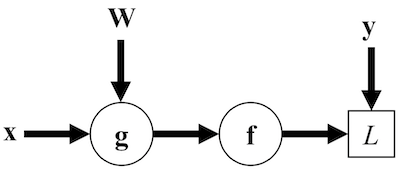

- What if we also want to learn the feature vectors?
  - Replace $\mathbf{x}$ with a feature extractor.
  - For simplicity, we can reuse the same "unit" as the classifier to compute the "features".

- Replace $\mathbf{x}$ with feature extractor $\mathbf{z}=\sigma(\mathbf{A}^T\mathbf{x})$
  - $\mathbf{z}$ is the extracted feature vector (also called *hidden* nodes)
    - $z_i = \sigma(\mathbf{a}_i^T \mathbf{x})$ is a  hidden node.
  - $\sigma()$ is the sigmoid function (also called *activation* function.)
  - $\mathbf{A}$ are the parameters of the feature extractor.

- New model 
  - $\mathbf{z} = \sigma(\mathbf{A}^T\mathbf{x})$
  - $\mathbf{g} = \mathbf{W}^T\mathbf{z}$
  - $\mathbf{f} = \mathbf{s}(\mathbf{g})$

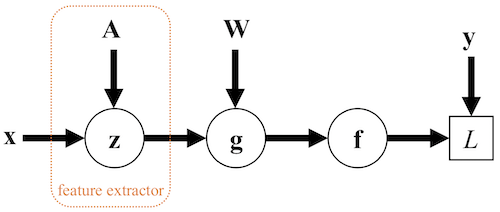

- **Interpretation**
  - Each hidden node $z_i$ is a "classifier" looking for pattern based on $\mathbf{a}_i$.
  - The output is looking for patterns in the vector $\mathbf{x}$
  - the effect is a non-linear classifier in the input space of $\mathbf{x}$.

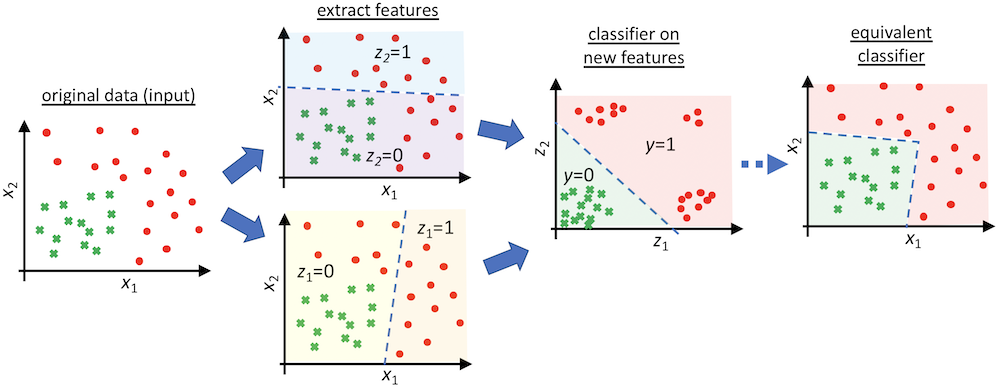

  - we can apply this recursively to create features of features ...

# Multi-layer Perceptron
- Add hidden layers between the inputs and outputs
  - each hidden node is a Perceptron (with its own set of weights)
    - its inputs are the outputs from previous layer
    - extracts a feature pattern from the previous layer
  - can model more complex functions

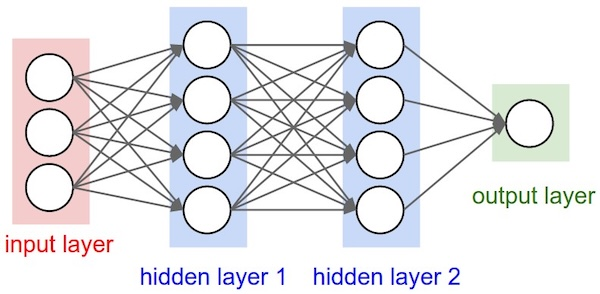

- Formally, for one layer: 
  - $\mathbf{h} = f(\mathbf{W}^T \mathbf{x})$
    - Weight matrix $\mathbf{W}$ - one column for each node
    - Input $\mathbf{x}$ - from previous layer
    - Output $\mathbf{h}$ - to next layer
    - $f(a)$ is the activation function - applied to each dimension to get output
- Also called _fully-connected layers_ or _dense layers_

# Activation functions
- There are different types of activation functions:
  - _Sigmoid_ - output [0,1]
  - _Tanh_ - output [-1,1]
  - _Rectifier Linear Unit (ReLU)_ - output [0,$\infty$]


In [5]:
x=linspace(-5,5,200)
fs = {'Sigmoid': lambda x: 1/(1+exp(-x)),
      'Tanh':    lambda x: tanh(x),
      'ReLU':    lambda x: maximum(0,x),
     }

actfig = plt.figure()
for name,f in fs.items():
    plt.plot(x, f(x), label=name)
plt.legend(loc="lower right")
plt.axis([-5,5,-2,2])
plt.grid(True)
plt.close()

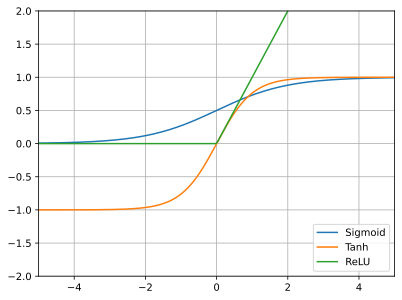

In [6]:
actfig

- Activation functions specifically for output nodes:
  - _Linear_ - output for regression
  - _Softmax_ - output for classification (same as multi-class logistic regression)
- Each layer can use a different activation function.

# Example on MNIST Dataset
- Images are 28x28, digits 0-9
  - 60,000 for training
  - 10,000 for testing

In [7]:
from torchvision import datasets, transforms

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

egs = []
for i in range(50):
    image, label = train_dataset[i]
    egs.append(image.squeeze())

In [8]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()
    plt.show()
    plt.close()

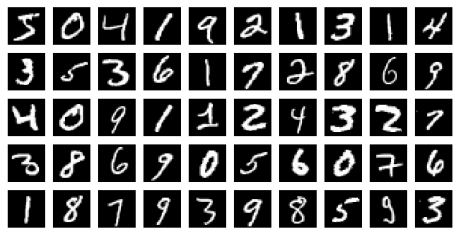

In [9]:
# Example images
plt.figure(figsize=(8,4))
show_imgs(egs)

# Initialize PyTorch

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

print(f"Using pytorch version: {torch.__version__}")

if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print(f"Using: {torch.cuda.get_device_name(device)}")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
    print(f"Using: Apple MPS")
else:
    raise("no GPU available")

Using pytorch version: 2.8.0
Using: Apple MPS


# Pre-processing
- Load the dataset
  - images are mapped to [0,1]
  - normalize mean and standard deviation

In [11]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# MNIST - Logistic Regression
- Input 28*28 vector, Output class label
- The output layer is the logit of the classifier (before softmax)

In [12]:
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

# load the model
model = LogisticRegression().to(device)
model.load_state_dict(torch.load('models/mnist_lr.pth'))
print(model)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


- Evaluate the model

In [13]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    # loop over test batches
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        # get classifier output
        outputs = model(data)
        # get class label with largest prediction
        _, predicted = torch.max(outputs.data, 1)
        # check correctness
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 91.96%


- Examine the weights of the network
  - Logit for class $j$: $g_j(\mathbf{x}) = \mathbf{w}_j^T\mathbf{x}$
    - reshape $\mathbf{w}_j$ into an image.
    - This is the "pattern" that is matched for class $j$
    - Assuming images are real values (both positive and negative values)
      - white * white = positive * positive -> positive response
      - black * black = negative * negative -> positive response
      - white * black = positive * negative -> negative response

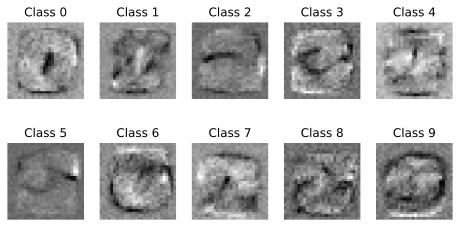

In [16]:
# get the weights for the logit layer
weights = model.linear.weight.data.cpu()

# reshape into an image
lr_weights = [x.reshape(28,28) for x in weights]

plt.figure(figsize=(8,4))
show_imgs(lr_weights, nc=5, titles="Class %d")

# MNIST - 1 hidden layer
- Add 1 hidden layer with 50 ReLU nodes
  - each hidden node is extracting a feature from the input image.
  - the classifier logit layer uses these 50 features

In [17]:
# 1-hidden-layer neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)  # Hidden layer with 50 units
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)     # Output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# create the model and load the trained weights
model = SimpleNN().to(device)
model.load_state_dict(torch.load('models/mnist_1nn.pth'))
print(model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


- Evaluate the model

In [18]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 97.47%


- Examine the weights of the hidden layer
  - $z_i = \sigma(\mathbf{a}_i^T \mathbf{x})$
  - each weight vector is a "pattern prototype" that the node will match
- The hidden nodes look for local structures:
  - oriented edges, curves, other local structures

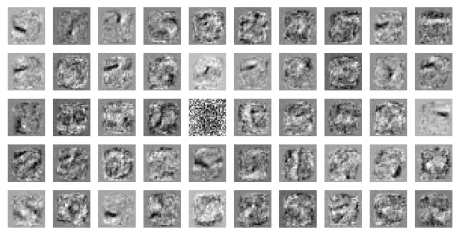

In [20]:
# Extract weights from the hidden layer
hidden_weights = model.fc1.weight.data.cpu()

# reshape into an image
nn1_weights = [x.reshape(28,28) for x in hidden_weights]

plt.figure(figsize=(8,4))
show_imgs(nn1_weights, nc=10)

- Examine the weights of the 2nd layer (output)
  - $g_j = \mathbf{w}_j^T\mathbf{z}$
  - recall the hidden-layer outputs $z$ are always non-negative (because of the ReLU activation).
    - positive value in $\mathbf{w}_j$ $\rightarrow$ class $j$ should have that pattern
    - negative value in $\mathbf{w}_j$ $\rightarrow$ class $j$ shouldn't have that pattern

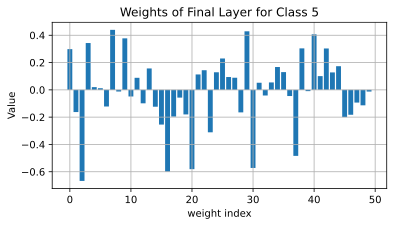

In [21]:
# Assuming your model is named 'model' and has a final layer called 'fc2'
# Extract the weights from the final layer
output_weights = model.fc2.weight.data.cpu()

# Select the weights corresponding to class 5
class_index = 5
W = output_weights[class_index].numpy()

# Plot the weights as a bar chart
plt.figure(figsize=(6, 3))
plt.bar(range(len(W)), W)
plt.title('Weights of Final Layer for Class {}'.format(class_index))
plt.xlabel('weight index'); plt.ylabel('Value')
plt.grid(True)
plt.show()

- For "5", finds local image parts that correspond to 5
  - should have (green boxes):
    - horizontal line at top; semicircle on the bottom
    - black horizontal line on top right
    - black horizontal line on bottom left
  - shouldn't have (red boxes):
    - vertical line on top; verticle line in the middle

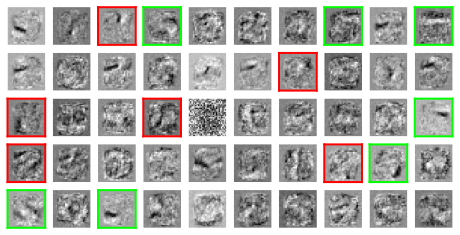

In [22]:
plt.figure(figsize=(8,4))
show_imgs(nn1_weights, nc=10,
          highlight_green=(W>0.3), # positive weights are green
          highlight_red=(W<-0.3))  # negative weights are red

# Signals
- So far we have assumed the input $\mathbf{x}$ is a vector
  - or have turned 2D images into vectors.
- _What if the input has more structure?_

- **1-D signal** (time)
  - mono audio (1 feature)
 
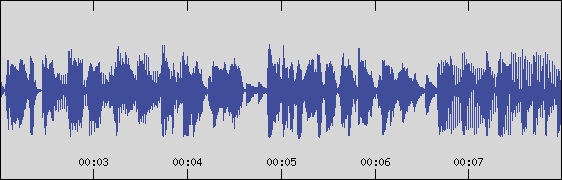

  - stereo audio  (2 features)

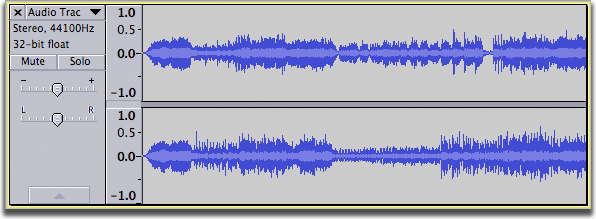

- **2-D signal** (space)
  - grayscale image (1 feature)

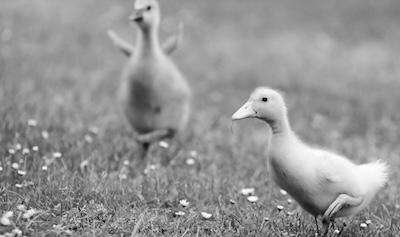

  - color image (3 features)
    
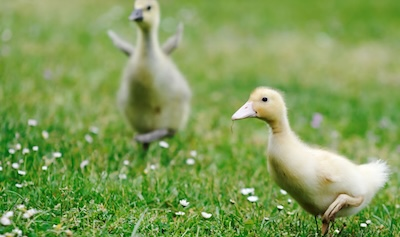
 
  - hyperspectral image (300 features)
 
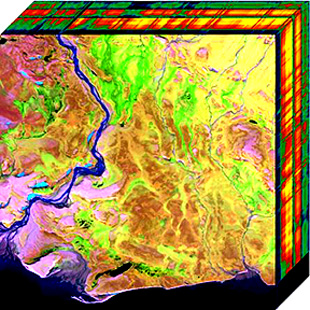
 

- **3-D signal** (space+time, volume)
  - color video (3 features)

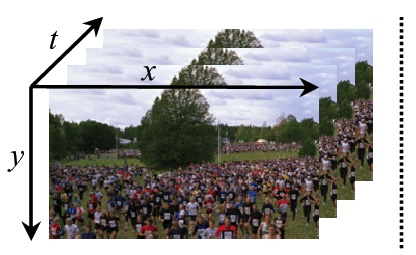

  - 3D CT scan (1 feature)

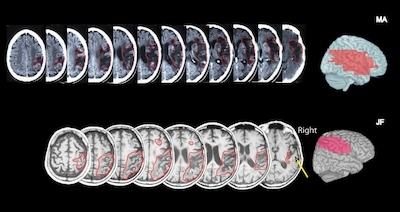

# Assumed Properties of Signals
- *Locality*
  - at low-level, features from 1 region  are independent (do not depend on) features from a far-away region.
 
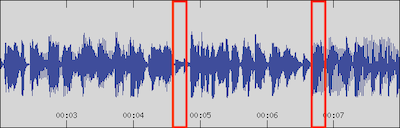

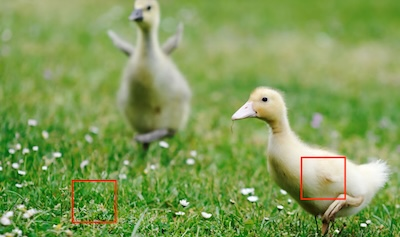

- *Translation* 
  - the same features can appear anywhere in the signal.

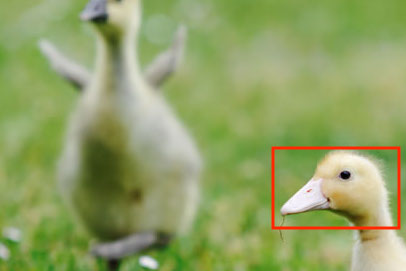
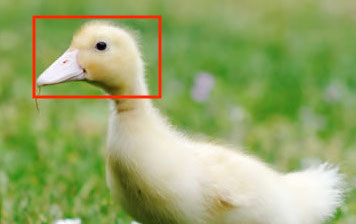

# Using the standard MLP layer...
- Each feature $z_i$ is computed from all the inputs, but we only want local features (locality).
- The pattern could appear anywhere, but weights are trained for each location $z_i$ separately (translation).

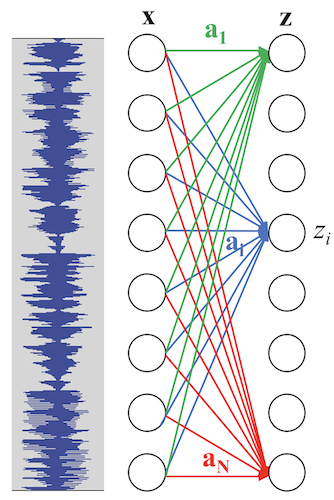

- For image input, we transform the image into a vector, which is the input into the MLP.    
- **Problem:** This ignores the spatial relationship between pixels in the image.
  - Images contain local structures 
    - groups of neighboring pixels correspond to visual structures (edges, corners, texture).
    - pixels far from each other are typically not correlated.

- **Solution**: Use a local feature extractor in the signal.
  - allow feature translation

# Convolution
- Consider 1D signal in *discrete* time: $x(t)$, $t \in \mathbb{Z}$
- Define the filter $w(t)$ 
  - "flipped" filter: $\tilde{w}(t) = w(-t)$  

In [23]:
from scipy import signal

def zeropad(w, left0, right0):
    return concatenate([zeros(left0,), w, zeros(right0,)])

def zeropad2(w, left0, right0, up0, down0):
    ws = w.shape;
    x = concatenate([
        zeros(shape=(up0,left0+ws[1]+right0)), 
        concatenate([
            zeros(shape=(ws[0], left0)),
            w,
            zeros(shape=(ws[0], right0))
        ], axis=1), 
        zeros(shape=(down0, left0+ws[1]+right0))
    ])
    return x

In [24]:
random.seed(4487)
x = linspace(-3,3,30) + 0.3*random.normal(size=(30,))
w = [1/3, 1/3, 1/3]
ww = zeropad(w,5,5)
tw = flip(w)

xfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.stem(x)
plt.grid(True)
plt.xlabel('t')
plt.title('x(t)')
plt.subplot(1,2,2)
plt.stem(arange(-6,7), ww)
plt.xlabel('t')
plt.title('w(t)')
plt.grid(True)
plt.close()

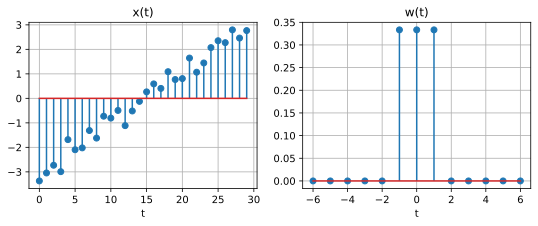

In [25]:
xfig

- Convolution is a filtering operation
  - $s(t) = x * w = \sum_a x(a) w(t-a)$
    - "$*$" is the symbol for convolution
- It's related to cross-correlation with the "flipped" filter.
  - $s(t) = \sum_a  x(a) \tilde{w}(a-t)$
  - for a given $t$:
    1. shift $\tilde{w}$ by $t$
    2. multiply shifted $\tilde{w}$ with $x$
    3. sum to get $s(t)$

In [26]:
s = convolve(x, w)

sfig = plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.stem(x)
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$x(a)$')
plt.xlabel('a')
plt.subplot(3,1,2)
plt.stem(range(-2,1), tw)
plt.stem(range(10,13), tw, markerfmt='or')
plt.stem(range(20,23), tw, markerfmt='om')
plt.stem(range(29,32), tw, markerfmt='og')
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$\\tilde{w}(a-t)$')
plt.xlabel('a')
plt.stem(zeros(30,), markerfmt=',r')
plt.subplot(3,1,3)
plt.stem(range(-1,31), s)
plt.xlim(-3,32); plt.grid(True)
plt.ylabel('$s(t)$')
plt.xlabel('t')
#plt.subplots_adjust(hspace=0.35)
plt.tight_layout()
plt.close()



- $s(t) = \sum_a  x(a) \tilde{w}(a-t)$
  1. shift $\tilde{w}$ by $t$
  2. multiply shifted $\tilde{w}$ with $x$
  3. sum to get $s(t)$

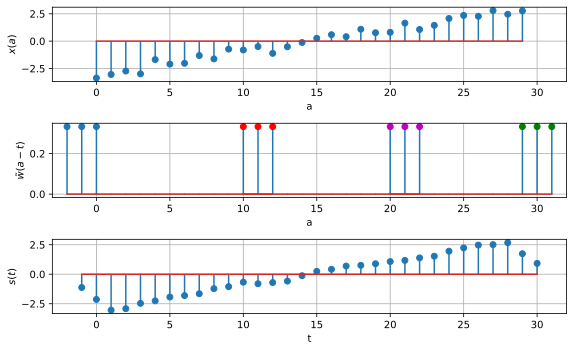

In [27]:
sfig

# 2D Convolution
- Straightforward to extend to multiple dimensions
- 2D discrete convolution
  $$s(n,m) = x*w = \sum_a \sum_b x(a,b) w(n-a, m-b)$$
- equivalent to 2D cross-correlation with flipped filter $\tilde{w}(n,m)=w(-n,-m)$
  $$s(n,m) = \sum_a \sum_b x(a,b) \tilde{w}(a-n, a-m)$$


In [28]:
X = train_dataset.data[0].numpy()
W = array([[1,1,1],[1,1,1], [1,1,1]])/9.

sfig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(X, cmap='gray')
plt.title('x(n,m)')
plt.subplot(1,3,2)
plt.imshow(zeropad2(W, 5, 5, 5, 5), cmap='gray')
plt.title('w(n,m)')
plt.subplot(1,3,3)
plt.imshow(signal.convolve2d(X,W), cmap='gray')
plt.title('s(n,m)')
plt.close()

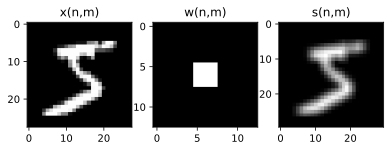

In [29]:
sfig

- **Interpretation**
  - $\tilde{w}$ is a pattern (template); try to find this pattern.
  - the maximum correlation occurs when pattern $\tilde{w}$ matches the local $x$.
    - for a fixed energy $||x||^2=1$,  $x=\frac{\tilde{w}}{||\tilde{w}||}$ has the maximum correlation with (response to) $\tilde{w}$.

In [30]:
X = train_dataset.data[0].numpy()
W = fliplr(flipud(X.astype('float64')))

XX = concatenate(
    [
        concatenate(train_dataset.data[[0,3,6,9]].numpy(), axis=1),
        concatenate(train_dataset.data[[1,2,5,0]].numpy(), axis=1),
        concatenate(train_dataset.data[[7,0,4,10]].numpy(), axis=1)
    ],
    axis=0
).astype('float64')

In [31]:
pfig = plt.figure(figsize=(8,6))
plt.subplot(1,3,1)
plt.imshow(XX, cmap='gray')
plt.title('image $x$')
plt.subplot(1,3,2)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.title('pattern $\\tilde{w}$')
plt.subplot(1,3,3)
plt.imshow(signal.convolve2d(XX,W,mode='same'), cmap='gray')
plt.title('response s=x*w')
plt.close()



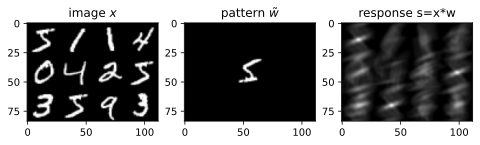

In [32]:
pfig

# Convolution as a layer
- output layer is the convolution of input with filter (kernel) $\mathbf{w}$.
  - $\mathbf{z} = \mathbf{x} * \mathbf{w}$.
- filter $\mathbf{w}$ acts locally on input $\mathbf{x}$.
  - $\mathbf{w}$ also called a **kernel**.

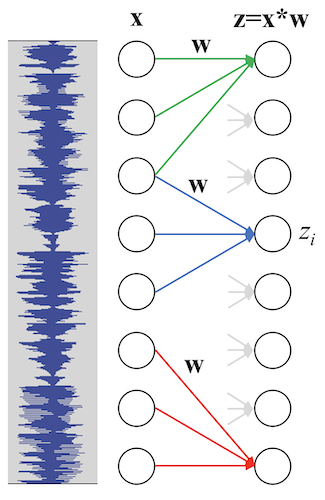

- Equivalent to a linear transformation (layer) where $A$ has a particular form.
  - For example, if $\mathbf{w} = [w_1,w_2,w_3]$ and using "same" mode, 
$$\begin{aligned}\mathbf{z} &= \mathbf{x}*\mathbf{w} \\ &= \mathbf{A}^T \mathbf{x} = \begin{bmatrix}w_2 & w_3&0&0&0&0&\cdots\\ w_1 & w_2 & w_3 &  0 & 0 & 0&\cdots\\0 & w_1 & w_2 & w_3 & 0 & 0& \cdots \\ 0 & 0 & w_1 & w_2 & w_3 & 0 & \cdots\\ \cdots & \end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\\\vdots\\x_N\end{bmatrix}\end{aligned}$$
  - Note: $\mathbf{A}$ has size $|\mathbf{x}||\mathbf{z}|$, but only $|\mathbf{w}|$ parameters.

# Translation equivariance
- Shifting $x$ also shifts the response $s$.
- if $s=x*w$,
  - then $s(t-a) = x(t-a)*w(t)$
- We can find the pattern everywhere in $x$ using the same filter. 

In [33]:
X = train_dataset.data[0].numpy()
W = fliplr(flipud(X.astype('float64')))

XX = concatenate(
    [
        concatenate(train_dataset.data[[4,4,4,4]].numpy(), axis=1),
        concatenate(train_dataset.data[[4,0,4,4]].numpy(), axis=1),
        concatenate(train_dataset.data[[4,4,4,4]].numpy(), axis=1)
    ],
    axis=0
).astype('float64')


XX2 = concatenate(
    [
        concatenate(train_dataset.data[[4,4,4,4]].numpy(), axis=1),
        concatenate(train_dataset.data[[4,4,0,4]].numpy(), axis=1),
        concatenate(train_dataset.data[[4,4,4,4]].numpy(), axis=1)    
    ],
    axis=0
).astype('float64')


cfig = plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.imshow(XX, cmap='gray')
plt.title('image $x$')
plt.subplot(2,3,2)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.title('pattern $\\tilde{w}$')
plt.subplot(2,3,3)
plt.imshow(signal.convolve2d(XX,W,mode='same'), cmap='gray')
plt.title('response s=x*w')

plt.subplot(2,3,4)
plt.imshow(XX2, cmap='gray')
plt.subplot(2,3,5)
plt.imshow(zeropad2(W, 42, 42, 28, 28), cmap='gray')
plt.subplot(2,3,6)
plt.imshow(signal.convolve2d(XX2,W,mode='same'), cmap='gray')
plt.close()
        




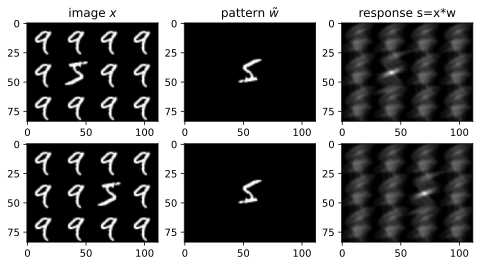

In [34]:
cfig

# Convolutional Neural Network (CNN)
- series of convolutional layers, sub-sampling layers, and MLP classifier.
  - convolutional and subsampling layers extract image features.
  - MLP uses extracted features for classification.

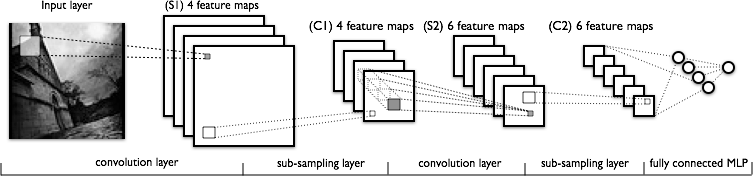

# 2D Convolution
- Use the spatial structure of the image
- 2D convolution filter
  - the weights $\mathbf{W}$ form a 2D filter template
  - filter response: $h = f(\sum_{x,y} W_{x,y} P_{x,y})$
    - $\mathbf{P}$ is an image patch with the same size as $\mathbf{W}$.
- Convolution feature map
  - pass a sliding window over the image, and apply filter to get a _feature map_.

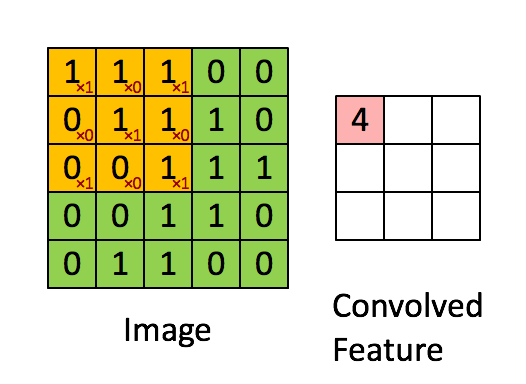

# 2D Convolutional layer
  - **Input:** HxW image with C channels
    - For example, in the first layer, C=3 for RGB channels.
    - defines a 3D volume: C x H x W (or H x W x C)
  - **Features:** apply F convolution filters to get F feature maps.
    - Each feature map uses a 3D convolution filter (CxKxK) on the input
    - K is the spatial extent of the filter; total FCKK parameters
  - **Activation:** 
    - an activation function can be applied before output
  - **Output:** a feature map with F channels 
    - defines a 3D volume: F x H' x W' 
    - H' and W' depend on various factors.
    
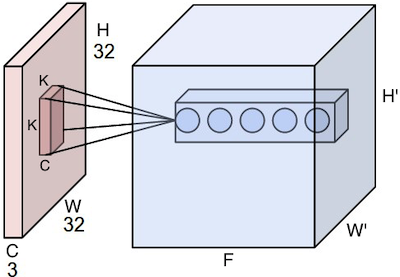

# Combining Convolutional Layers
- Concatenate several convolutional layers.
  - From layer to layer
    - spatial resolution decreases
    - number of feature maps increases
  - Can extract high-level features in the final layers
- Feature map representation:

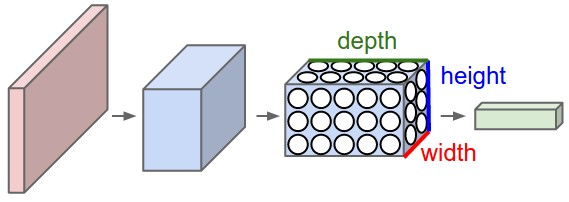

# Spatial sub-sampling
- reduce the feature map size by subsampling feature maps between convolutional layers
  - *stride* for convolution filter - step size when moving the windows across the image.
 
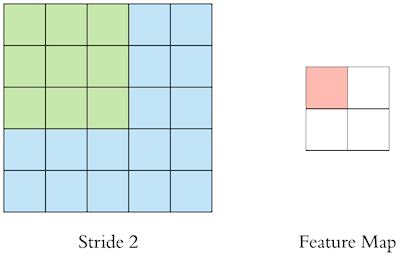

- Spatial sub-sampling
  - *max-pooling layer* - use the maximum over a pooling window
    - gathers features together, summarizes features in local region.
  - introduces **translation invariance**
    - it doesn't matter where the maximal feature is located locally, it is passed to the next layer.
    - increases robustness to small changes in configuration of features

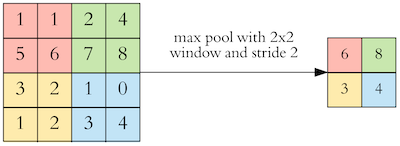

# Receptive field size
- Stacking convolutional layers increases the effective size of the pattern filter
  - called **receptive field** - what pixels in the input affect a particular node.
  - larger receptive fields can see larger patterns.
  - Example: 2 convolutional layers
    - $|\mathbf{w_1}| = 5, |\mathbf{w_2}| = 3$,  receptive field size = $|\mathbf{w_1}| + |\mathbf{w_2}| - 1 = 7$
  
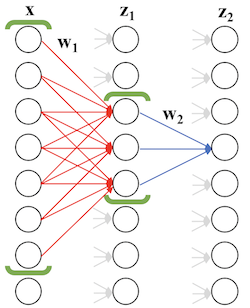

# Fully-connected layers (MLP)
  - after several convolutional layers, input the feature map into an MLP to get the final classification.
  - also called "fully-connected" (FC) layers.

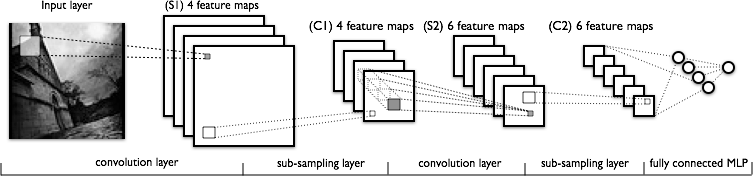

# Example: Object classification CNN
- Each layer shows its feature maps for the example image.
  - early layers extract *low-level* (visual) features
    - e.g., corners, edges
  - middle layers extract *mid-level* (part) features
    - e.g., object parts
  - later layers extract *high-level* (semantic) features.
    - e.g., object
    
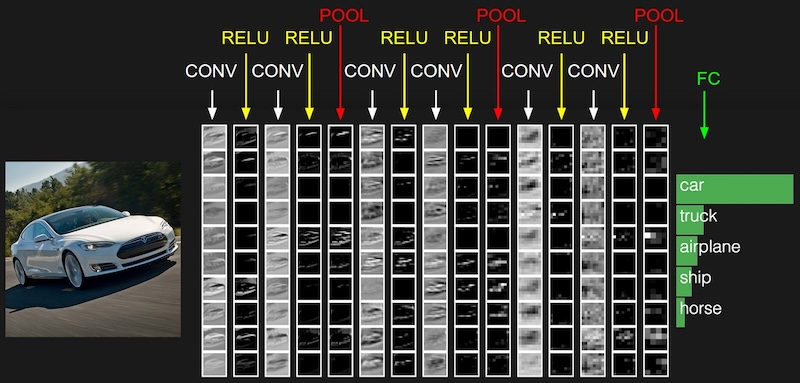

- The number of feature channels increases with each layer
  - combining low-level parts together to get more higher-level parts
    - e.g., {edges, corners} ->  {wheel, door, window}
  - trading off spatial resolution for semantic specificity
    - e.g., 512x512x3 RGB image -> 8x8x512 semantic features
- the spatial resolution decreases with each layer
  - increase the window size (receptive field) on the object
  - high-level semantic correspond to large regions.

# Example on MNIST: Shallow CNN
- 1 Convolution layer
  - 1x5x5 kernel, 10 features
  - Max pooling stride=2, kernel size=2
  - Input: 1x28x28 (grayscale image) -> Output: 10x12x12
- 1 fully-connected layer (MLP hidden layer), 50 nodes
  - Input: 12x12x10=1440 -> Output: 50
  - ReLU activation
- 1 fully-connected layer (classifier)
  - linear layer (logits)

In [35]:
# Shallow CNN model
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)  # Output: 10x24x24
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                      # Output: 10x12x12
        self.fc1 = nn.Linear(10 * 12 * 12, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Shape: [batch_size, 10, 12, 12]
        x = x.view(-1, 10 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# load the model
model = ShallowCNN().to(device)
model.load_state_dict(torch.load('models/mnist_cnn1.pth'))
print(model)

ShallowCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1440, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


- Evaluate the model

In [36]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 98.67%


- Visualize the convolutional filters
  - filters are looking for local stroke features
    - corners, edges, lines

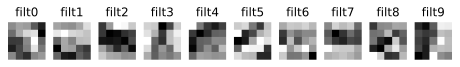

In [37]:
# Extract filters from the first convolutional layer
filters = model.conv1.weight.data.cpu()

filter_list = [f[0] for f in filters]

plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=10, titles='filt%d')

- visualize the MLP hidden layer
  - each node looks at the whole 10x12x12 map
  - each row corresponds to one node: each image shows the weights for one channel
    - hard to interpret...

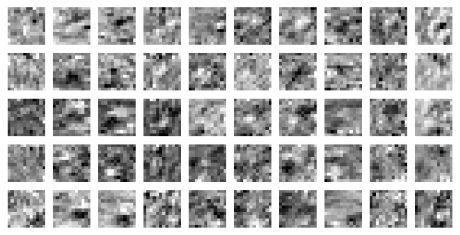

In [39]:
# Extract weights from fc1
weights = model.fc1.weight.data.cpu()

weights_list = []
for i in [0,2,4,5,7]:
    # Reshape each hidden unit's weights to (10, 12, 12)
    weight_tensor = weights[i].reshape(10, 12, 12)

    # show each of the 10 weight maps for channel i
    for j in range(10):
        weights_list.append(weight_tensor[j])

plt.figure(figsize=(8,4))
show_imgs(weights_list, nc=10)

# Summary
- **Multi-layer perceptron (MLP)**
  - collection full-connected (or dense) layers
  - non-linear activation function
- **Convolutional neural network (CNN)**
  - convolution filters for extracting local image features
    - global translation equivariance
  - local translation invariance using max-pooling
  - classifier using MLP on the image features.
  - learns to extract image features and the classifier simultaneously.

- **Advantages**
  - lots of parameters - large capacity to learn from large amounts of data
- **Disadvantages**
  - lots of parameters
  - hard to interpret for internal layers of larger (deeper) networks


# References

- Software
  - Pytorch - https://pytorch.org/
- PyTorch tutorials:
  - https://docs.pytorch.org/tutorials/beginner/basics/intro.html
- History:
  - http://www.andreykurenkov.com/writing/a-brief-history-of-neural-nets-and-deep-learning/
- Online courses::
  - http://cs231n.github.io/neural-networks-1/
  - http://cs231n.github.io/convolutional-networks/